# (PriCON2020 Demo) - SyferText_0.1.0
------

**Author:**

- Alan Aboudib:  [Twitter](https://twitter.com/alan_aboudib) | [LinkedIn](https://www.linkedin.com/in/ala-aboudib/) | [Slack](https://app.slack.com/client/T6963A864/DDKH3SXKL/user_profile/UDKH3SH8S)

-----

## -1. The Tokenizer

In [1]:
# Imports
import syfertext
from syfertext.tokenizer import Tokenizer

import syft as sy

import torch
hook = sy.TorchHook(torch) 

me = hook.local_worker
me.is_client_worker = False

bob = sy.VirtualWorker(hook, id = 'bob')
alice = sy.VirtualWorker(hook, id = 'alice')
charlie = sy.VirtualWorker(hook, id = 'charlie')
dan = sy.VirtualWorker(hook, id = 'dan')
bill = sy.VirtualWorker(hook, id = 'bill')
james = sy.VirtualWorker(hook, id = 'james')

In [2]:
# A utility function print pipeline-related objects deployed
def show_pipeline_objects(worker, pipeline_prefix):
    
    for k in list(worker._objects.keys()):
        if str(k).startswith(pipeline_prefix):
            print(str(k).ljust(40), '|  ', worker._objects[k])

In [3]:
# A function to empty a worker's object store
def reset_object_store(worker):
    
    keys = list(worker._objects)
    for k in keys:
        del worker._objects[k]

--------

In [4]:
# Create a pipeline using a Language object
nlp_test1 = syfertext.create(pipeline_name = "syfertext_pricon_test1")

# Create a tokenizer
tokenizer = Tokenizer(suffixes=None,
                      prefixes = None,
                      infixes = ['_'],
                      exceptions = {'manmade': [{'ORTH': 'man'},{'ORTH':'made'}]}
                     )

# Add the tokenizer to the pipeline
nlp_test1.set_tokenizer(tokenizer = tokenizer,  
                        access = {"*"})

## - 2. The Simple Tagger

In [5]:
# Let's create a simple tagger to tag tokens that are animal.
from syfertext.pipeline import SimpleTagger

animal_tagger = SimpleTagger(attribute = 'is_animal',
                             lookups = ['dog', 'cat', 'horse', 'cow'],
                             tag = True,
                             default_tag = False,
                             case_sensitive = False
                          )

# Add the animal tagger to the pipeline
nlp_test1.add_pipe(name = 'animal tagger',
                   component = animal_tagger,
                   access = {'*'}
                  )

Let's see what heppened:

In [6]:
nlp_test1.pipe_names

['tokenizer', 'animal tagger']

In [7]:
nlp_test1.pipeline

{}

In [8]:
# Deploy it on PyGrid
nlp_test1.deploy(worker = charlie)

**Let's tokenize some strings**

In [9]:
reset_object_store(me)

In [10]:
show_pipeline_objects(charlie, 'syfertext')

syfertext_pricon_test1:tokenizer         |   State>None
syfertext_pricon_test1:animal tagger     |   State>None
syfertext_pricon_test1                   |   Pipeline>None


In [11]:
show_pipeline_objects(me, 'syfertext')

----

In [12]:
# Load the model from the deployed version
nlp_test1 = syfertext.load('syfertext_pricon_test1')
nlp_test1

Language>None

In [13]:
show_pipeline_objects(me, 'syfertext')

syfertext_pricon_test1                   |   Pipeline>None


In [14]:
from syft.generic.string import String

text = String("I saw a dog playing with a manmade cat. A horse and a cow were there watching!")

doc = nlp_test1(text)

In [15]:
show_pipeline_objects(me, 'syfertext')

syfertext_pricon_test1                   |   Pipeline>None
syfertext_pricon_test1:tokenizer         |   State>None
syfertext_pricon_test1:animal tagger     |   State>None


In [16]:
for token in doc:
    print(token.text.ljust(10), '|',
          f"animal? {token._.is_animal}".ljust(15), '|',
          f"punct? {token.is_punct}".ljust(15), '|',
          f"oov? {token.is_oov}".ljust(15), '|'
          f"stopword? {token.is_stop}".ljust(15),
         )

I          | animal? False   | punct? False    | oov? True       |stopword? True
saw        | animal? False   | punct? False    | oov? True       |stopword? False
a          | animal? False   | punct? False    | oov? True       |stopword? True
dog        | animal? True    | punct? False    | oov? True       |stopword? False
playing    | animal? False   | punct? False    | oov? True       |stopword? False
with       | animal? False   | punct? False    | oov? True       |stopword? True
a          | animal? False   | punct? False    | oov? True       |stopword? True
man        | animal? False   | punct? False    | oov? True       |stopword? False
made       | animal? False   | punct? False    | oov? True       |stopword? True
cat        | animal? True    | punct? False    | oov? True       |stopword? False
.          | animal? False   | punct? True     | oov? True       |stopword? False
A          | animal? False   | punct? False    | oov? True       |stopword? True
horse      | animal? T

-- Now let's tokenize a remote string

In [17]:
text = String("I saw a dog playing with a manmade cat. A horse and a cow were there watching!")
text = text.send(dan)

doc = nlp_test1(text)

type(doc)

syfertext.pointers.doc_pointer.DocPointer

In [18]:
show_pipeline_objects(dan, 'syfertext')

syfertext_pricon_test1:tokenizer         |   State>None
syfertext_pricon_test1:animal tagger     |   State>None


In [19]:
nlp_test1.pipeline

{'me': [SubPipeline[tokenizer > animal tagger]],
 'dan': [[SubPipelinePointer | me:7172858845 -> dan:50395814871]]}

In [20]:
nlp_test1.subpipeline_templates

defaultdict(list,
            {'me': [{'names': ['tokenizer', 'animal tagger'],
               'location': 'me'}],
             'dan': [{'names': ['tokenizer', 'animal tagger'],
               'location': 'dan'}]})

## -3. Create a pipeline with word embeddings

In [21]:
nlp_spacy = syfertext.create(pipeline_name = "spacy_en_core_web_lg_reduced")

In [22]:
# Create the tokenizer
tokenizer = Tokenizer()

In [23]:
## Prepare vectors to create the vocabulary
import pickle

# Replace with pathes on your machine
hash2row_path = '../../../language_models/syfertext_en_core_web_lg/syfertext_en_core_web_lg/data/key2row'
vectors_path = '../../../language_models/syfertext_en_core_web_lg/syfertext_en_core_web_lg/data/vectors'

# Load the key2row dict
with open(hash2row_path, "rb") as hash2row_file:
    hash2row = pickle.load(hash2row_file)
    
# Load the vectors
with open(vectors_path, "rb") as vectors_file:
    vectors = pickle.load(vectors_file)

In [24]:
hash2row

{15748096671724166044: 303,
 17130787002665352158: 197,
 7803463073553212047: 4790,
 2570228442999028682: 2,
 7601031270107461210: 1,
 2333086044707505052: 64,
 17583811671891633967: 13004,
 16386776449441186651: 153473,
 17917450762234962061: 90212,
 2845569251850464646: 4890,
 6441753959142598228: 4589,
 11219611539707024218: 13230,
 6174446835319589640: 15533,
 13726421824593857419: 20011,
 1504634659258364126: 11242,
 16574276769445059825: 223926,
 7229085451700080888: 2103,
 13398808308607858859: 12860,
 10584754210639909977: 684823,
 13533255182131191051: 15807,
 15291897178858464945: 12234,
 5645781836273801443: 74739,
 14842797775714447761: 184394,
 16296342147116913380: 49979,
 13009980616664168188: 146852,
 648685765859229059: 37622,
 1532234788270237555: 138949,
 3160290493673410775: 5778,
 7192950948311231314: 55492,
 898812733540616898: 74660,
 5065724982986493403: 7029,
 12145149956222337371: 11285,
 2577432275152706222: 1305,
 10614879281046276072: 31329,
 11631803523755

In [25]:
vectors.shape

(684831, 300)

In [26]:
from syfertext.vocab import Vocab

# Create a Vocab object
vocab = Vocab(hash2row = hash2row, vectors=vectors)

In [27]:
# Add the tokenizer and the vocabulary to the pipeline
nlp_spacy.set_tokenizer(tokenizer = tokenizer, 
                        access = {'*'})

nlp_spacy.set_vocab(vocab = vocab, 
                    access = {'*'})

In [28]:
# Deploy
nlp_spacy.deploy(worker=charlie)

In [29]:
show_pipeline_objects(charlie, 's')

spacy_en_core_web_lg_reduced:tokenizer   |   State>None
spacy_en_core_web_lg_reduced:vocab       |   State>None
spacy_en_core_web_lg_reduced             |   Pipeline>None


In [30]:
reset_object_store(me)

----

## Use Case

## 1. Download the Dataset

In [31]:
# Useful imports
# Import useful utility functions for this tutoria
from utils import download_dataset

from syft.generic.string import String

from syfertext.pipeline.simple_tagger import SimpleTagger

import numpy as np
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import os
from pprint import pprint
import pickle

sb.set()


Do not run the following cell if you already have the dataset downloaded

In [32]:
"""
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/AlanAboudib/dataset_imdb/master/%s'

# File names to be downloaded from the using the URL template above
files = ['imdb.csv', 'imdb_vocab.txt', 'imdb_polarity.txt', 'stop_word_en.txt']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'imdb'
root_path = './imdb'

# Create the dataset folder if it is not already there
if not os.path.exists('./imdb'):
    os.mkdir('./imdb')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )
"""

"\n# The URL template to all dataset files\nurl_template = 'https://raw.githubusercontent.com/AlanAboudib/dataset_imdb/master/%s'\n\n# File names to be downloaded from the using the URL template above\nfiles = ['imdb.csv', 'imdb_vocab.txt', 'imdb_polarity.txt', 'stop_word_en.txt']\n\n# Construct the list of urls\nurls = [url_template % file for file in files]\n\n# The dataset name and its root folder\ndataset_name = 'imdb'\nroot_path = './imdb'\n\n# Create the dataset folder if it is not already there\nif not os.path.exists('./imdb'):\n    os.mkdir('./imdb')\n\n# Start downloading\ndownload_dataset(dataset_name = dataset_name, \n                 urls = urls, \n                 root_path = root_path\n                )\n"

## 2. Simulating Private Datasets

In order to simulate two private datasets owned by two different clients, Bob and Alice. We will do the following:

1. Load the whole dataset in `imdb.csv` locally (the `me` worker). This dataset will be loaded as a list of dictionaries that has the following format: `[ {'review': <review text>, 'label': <1 or 0>}, {...}, {...}]`


2. Split the dataset into two parts, one for Bob and the other for Alice. Each part will be also split into a training set and a validation set. This will create four lists: `train_bob`, `valid_bob`, `train_alice`, `valid_alice`. Each list has the same format I mentioned above.


3. Each element in the four lists will be sent to the corresponding worker. This will change the content of the lists as depicted in **Figure(1)**. Each list willl hold PySyft pointers to the texts and labels instead of the objects themselves.

<div>
<br>
<img alt = 'imdb review remote datasets' src ='./art/imdb_review_remote.png' style='width:700px'>
<div>
<div style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<strong> Figure(1): </strong> The reviews and their labels are remotely located on Bob's and Alice's remote machines, only pointers to them are kept by the local worker (the company's machine).
</div>
</div>
<br>
</div>

# Create a remote Dataset

In [33]:
# Set the path to the dataset file
dataset_path = './imdb/imdb.csv'

# store the dataset as a list of dictionaries
# each dictionary has two keys, 'review' and 'label'
# the 'review' element is a PySyft String
# the 'label' element is an integer with 1 for 'positive'
# and 0 for 'negative' review
dataset_local = []

with open(dataset_path, 'r') as dataset_file:
    
    # Create a csv reader object
    reader = csv.DictReader(dataset_file)
    
    for elem in reader:
        
        # Create one entry
        example = dict(review = String(elem['review']),
                       label = 1 if elem['sentiment'] == 'positive' else 0
                      )
        
        # add to the local dataset
        dataset_local.append(example)

Here is how an element in the list looks like:

In [34]:
example = dataset_local[10]
pprint(example)

{'label': 0,
 'review': 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'}


Let's check out the data types:

In [35]:
print(type(example['review']))
print(type(example['label']))

<class 'syft.generic.string.String'>
<class 'int'>


This review text is a PySyft `String` object. The label is an integer.

Let's split the dataset into two equal parts and send each part to a different worker simulating two remote datasets as I mentioned above:

In [36]:
# Create two datasets, one for Bob, and the other for Alice

dataset_bob, dataset_alice = train_test_split(dataset_local[:250], train_size = 0.5)

# Now create a validation set for Bob, and another for Alice
train_bob, val_bob = train_test_split(dataset_bob, train_size = 0.7)
train_alice, val_alice = train_test_split(dataset_alice, train_size = 0.7)

And now I will make the dataset remote:

In [37]:
# A function that sends the content of each split to a remote worker
def make_remote_dataset(dataset, worker):

    # Got through each example in the dataset
    for example in dataset:
        
        # Send each review text
        example['review'] = example['review'].send(worker)

        # Send each label as a one-hot-enceded vector
        one_hot_label = torch.zeros(2).scatter(0, torch.Tensor([example['label']]).long(), 1)
        
        # Send the review label
        example['label'] = one_hot_label.send(worker)


Notice that the above function, transforms the label to a one-hot-encoded format before sending it to a remote worker. So if the sentiment is negative, the corresponding tensor will hold `[1,0]`, and if it is positive, the label will be `[0,1]`.

I can finally create the remote datasets:

In [38]:
# Bob's remote dataset
make_remote_dataset(train_bob, bob)
make_remote_dataset(val_bob, bob)

# Alice's remote dataset
make_remote_dataset(train_alice, alice)
make_remote_dataset(val_alice, alice)

Let me show you what an element of Bob's dataset look like:

In [39]:
# Take an element from the dataset
example = train_bob[2]

print(type(example['review']))
print(example['label'])

<class 'syft.generic.pointers.string_pointer.StringPointer'>
(Wrapper)>[PointerTensor | me:70409470041 -> bob:14429565514]


Wow, the text type is now a PySyft `StringPointer` that points to the real `String` object  located in Bob's machine. The label type is a PySyft `PointerTensor`. Let's check out the location of the real text and label:

In [40]:
print(example['review'].location)
print(example['label'].location)

<VirtualWorker id:bob #objects:250>
<VirtualWorker id:bob #objects:250>


The datasets are now ready, and so is the work environment. Let's start the fun with SyferText :) 

## 3. Create the new pipeline

In [41]:
# Load an existing pipeline from PyGrid
nlp_spacy = syfertext.load('spacy_en_core_web_lg_reduced')

In [42]:
nlp_spacy.states

{'tokenizer': {'state': State>None, 'access': {'*'}, 'location_id': 'charlie'},
 'vocab': {'state': State>None, 'access': {'*'}, 'location_id': 'charlie'}}

In [43]:
# Let's tokenize with the imported model
doc = nlp_spacy("I saw a dog playing with a manmade cat. A horse and a cow were there watching!")

for token in doc:
    print(token.text.ljust(10), '|',
          f"punct? {token.is_punct}".ljust(15), '|',
          f"oov? {token.is_oov}".ljust(15), '|'
          f"stopword? {token.is_stop}".ljust(15),
         )
    


I          | punct? False    | oov? False      |stopword? True
saw        | punct? False    | oov? False      |stopword? False
a          | punct? False    | oov? False      |stopword? True
dog        | punct? False    | oov? False      |stopword? False
playing    | punct? False    | oov? False      |stopword? False
with       | punct? False    | oov? False      |stopword? True
a          | punct? False    | oov? False      |stopword? True
manmade    | punct? False    | oov? False      |stopword? False
cat        | punct? False    | oov? False      |stopword? False
.          | punct? True     | oov? False      |stopword? False
A          | punct? False    | oov? False      |stopword? True
horse      | punct? False    | oov? False      |stopword? False
and        | punct? False    | oov? False      |stopword? True
a          | punct? False    | oov? False      |stopword? True
cow        | punct? False    | oov? False      |stopword? False
were       | punct? False    | oov? False      

The loaded model has word embeddings (that we are going to use for our usecase)

In [44]:
doc[0].vector

tensor([[ 1.8733e-01,  4.0595e-01, -5.1174e-01, -5.5482e-01,  3.9716e-02,
          1.2887e-01,  4.5137e-01, -5.9149e-01,  1.5591e-01,  1.5137e+00,
         -8.7020e-01,  5.0672e-02,  1.5211e-01, -1.9183e-01,  1.1181e-01,
          1.2131e-01, -2.7212e-01,  1.6203e+00, -2.4884e-01,  1.4060e-01,
          3.3099e-01, -1.8061e-02,  1.5244e-01, -2.6943e-01, -2.7833e-01,
         -5.2123e-02, -4.8149e-01, -5.1839e-01,  8.6262e-02,  3.0818e-02,
         -2.1253e-01, -1.1378e-01, -2.2384e-01,  1.8262e-01, -3.4541e-01,
          8.2611e-02,  1.0024e-01, -7.9550e-02, -8.1721e-01,  6.5621e-03,
          8.0134e-02, -3.9976e-01, -6.3131e-02,  3.2260e-01, -3.1625e-02,
          4.3056e-01, -2.7270e-01, -7.6020e-02,  1.0293e-01, -8.8653e-02,
         -2.9087e-01, -4.7214e-02,  4.6036e-02, -1.7788e-02,  6.4990e-02,
          8.8451e-02, -3.1574e-01, -5.8522e-01,  2.2295e-01, -5.2785e-02,
         -5.5981e-01, -3.9580e-01, -7.9849e-02, -1.0933e-02, -4.1722e-02,
         -5.5576e-01,  8.8707e-02,  1.

In [45]:
# Choose a name for the new pipeline
nlp_sentiment = syfertext.create('syfertext_sentiment')

In [46]:
# Add a tokenizer
tokenizer = Tokenizer()
nlp_sentiment.set_tokenizer(tokenizer = tokenizer, 
                            access= {'*'})

In [47]:
# Now add a vocab from 'spacy_en_core_web_lg_reduced'
vocab_spacy = nlp_spacy('').vocab

nlp_sentiment.set_vocab(vocab=vocab_spacy, access={'*'})

In [48]:
nlp_sentiment.pipe_names

['tokenizer']

In [49]:
nlp_sentiment.states

{'tokenizer': {'state': State>None, 'access': {'*'}},
 'vocab': {'state': State>None, 'access': {'*'}}}

### 3.1 Create a  tagger for stop words

We will start by creating the stop-word tagger. Let's first load the stop word file into a list of words:

In [50]:
from syfertext.stop_words import STOP_WORDS

STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

Now we create the tagger which is an object of the `SimpleTagger` class:

In [51]:
# Create a simple tagger object to tag stop words
stop_tagger = SimpleTagger(attribute = 'is_stop',
                           lookups = STOP_WORDS,
                           tag = True,
                           default_tag = False,
                           case_sensitive = False
                          )

Notice that I pass the list of words as the `lookups` arguments. 

Every token in the `Doc` object will be given a custom attribute called `is_stop`. Every time a stop word is found, this attribute will be given the value `True` specified by the `tag` argument of the `SimpleTagger` class initialiser, otherwise, the `default_tag` will be used, which I set to `False`.

### 3.2 Create a tagger for word polarity

In the same way we created a tagger for stop words. We are now going to create another tagger for polar words, i.e., words that are more biased toward a positive or a negative sentiment. Let's load the corresponding files `imdb_vocab.txt` and `imdb_polarity.txt`:

In [52]:
# Load the polarity info
with open('./imdb/imdb_vocab.txt', 'r') as f:
    imdb_words = f.read().splitlines()
    
with open('./imdb/imdb_polarity.txt', 'r') as f:
    polarity = [float(line) for line in f.read().splitlines()]

Let me show you the distribution of polarity values:

/home/alan/miniconda3/envs/syfertext/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


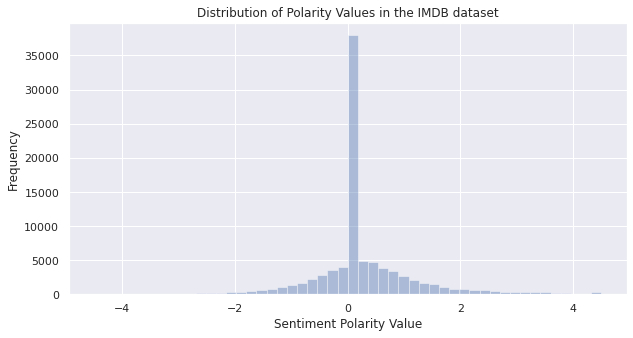

In [53]:
# Create the histogram of polarity values
fig, ax = plt.subplots(figsize = (10,5))
sb.distplot(polarity, kde = False, ax = ax)

ax.set_xlabel('Sentiment Polarity Value')
ax.set_ylabel('Frequency')
ax.set_title("Distribution of Polarity Values in the IMDB dataset");

Notice that the grand majority of words seem to be unbiased toward a specific sentiment. So let's create a tagger that tags only tokens that are most polar by setting a custom attribute we will call `is_polar` to `True` and `False` otherwise:

In [54]:
# Choose low/high polarity cutoff values
low_cutoff = -0.5
high_cutoff = 0.5

# Create a list of polar tokens
polar_tokens = [token for i, token in enumerate(imdb_words) 
                if polarity[i] > high_cutoff or
                polarity[i] < low_cutoff]

Using the list of polar wordsabove, we can now create the tagger:

In [55]:
polarity_tagger = SimpleTagger(attribute = 'is_polar',
                               lookups = polar_tokens,
                               tag = True,
                               default_tag = False,
                               case_sensitive = False
                              )

### 3.3 Adding the taggers to the pipeline

We can now add each tagger we created above to the the pipeline by using the `add_pipe()` method of the `Language` class. However, in the following cell, I give you the possibility to decide for yourself which components you wish to add.

Here is what I recommend you do:

1. First run this tutorial without adding an tagger.

2. Restart the notebook and run the tutorial again with `use_stop_tagger = True`.

3. Restart the notebook and run the tutorial again with both `use_stop_tagger = True` and `use_polarity_tagger = True`.

I will actually show you the results of each such run at the end of this notebook.

In [56]:
use_stop_tagger = True
use_polarity_tagger = True

# Tokens with these custom tags
# will be excluded from creating
# the Doc vector
excluded_tokens = {}

Notice that in the above cell. I create a dictionary called `excluded_tokens`. It will be used later in this tutorial when we create embedding vectors for reviews. It enables us to execlude some tokens when we create a document embedding. Such exclusion will be based on the value of the custom attributes we set with the taggers.

Now let's add the stop word tagger to the pipeline (If `use_stop_tagger = True`). Notice that I set the argument `remote = True`. This tells the `Language` object that it is allowed to send the pipe component to the remote worker.

In [57]:
if use_stop_tagger:

    # Add the stop word to the pipeline
    nlp_sentiment.add_pipe(name = 'stop tagger',
                 component = stop_tagger,
                 access = {'*'}
                )

    # Tokens with 'is_stop' = True are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_stop'] = {True}

Same for adding the polar word tagger:

In [58]:
if use_polarity_tagger:
    
    # Add the polarity tagger to the pipeline
    nlp_sentiment.add_pipe(name = 'polarity tagger',
                 component = polarity_tagger,
                 access = {'*'}
                )

    # Tokens with 'is_polar' = False are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_polar'] = {False}

Let's check out what pipe components are included in the pipeline:

In [59]:
nlp_sentiment.pipeline_template

[{'name': 'tokenizer', 'class_name': 'Tokenizer'},
 {'name': 'stop tagger', 'class_name': 'SimpleTagger'},
 {'name': 'polarity tagger', 'class_name': 'SimpleTagger'}]

## 4. Create a Dataset class

In [60]:
# Some necessary imports
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

# Create a summary writer for logging performance with Tensorboard
writer = SummaryWriter()

In [61]:
class DatasetIMDB(Dataset):
    
    def __init__(self, sets, share_workers, crypto_provider, nlp):

        self.sets = sets
        self.crypto_provider = crypto_provider
        self.workers = share_workers
    
        # Create a single dataset unifying all datasets.
        self._create_dataset()
        
        # The language model
        self.nlp = nlp
        
    def _create_dataset(self):
        """Create a single list unifying examples from all remote datasets
        """
        
        # Initialize the dataset
        self.dataset = []
      
        # Populate the dataset list
        for dataset in self.sets:
            for example in dataset:
                self.dataset.append(example)
        
    def __getitem__(self, index):

        
        # get the example
        example = self.dataset[index]
        
        # Run the preprocessing pipeline on 
        # the review text and get a DocPointer object
        doc_ptr = self.nlp(example['review'])
        
        # Get the encrypted vector embedding for the document
        vector_enc = doc_ptr.get_encrypted_vector(bob, 
                                                  alice, 
                                                  crypto_provider = self.crypto_provider,
                                                  requires_grad = True,
                                                  excluded_tokens = excluded_tokens,
                                                  protocol = 'fss'
                                                 )
        

        # Encrypt target label
        label_enc = example['label'].fix_precision()\
                                    .share(bob, 
                                           alice, 
                                           crypto_provider = self.crypto_provider,
                                           requires_grad = True,
                                           protocol = 'fss'

                                          )\
                                    .get()


        return vector_enc, label_enc

    
    def __len__(self):
        """Returns the combined size of all of the 
        remote training/validation sets.
        """
        
        # The size of the combined datasets
        return len(self.dataset)


                
    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch
        vectors, targets = list(zip(*batch))

        # concatenate the vectors
        vectors = torch.stack(vectors)
        
        #concatenate the labels
        targets = torch.stack(targets)
        
        return vectors, targets

Let's now create two such `DatasetIMDB` objects, one for training and the other for validation:

In [62]:
# Instantiate a training Dataset object
trainset = DatasetIMDB(sets = [train_bob,
                               train_alice],
                       share_workers = [bob, alice],
                       crypto_provider = dan,
                       nlp = nlp_sentiment
                      )

# Instantiate a validation Dataset object
valset = DatasetIMDB(sets = [val_bob,
                             val_alice],
                     share_workers = [bob, alice],
                     crypto_provider = dan,
                     nlp = nlp_sentiment
                    )

## 5. Create a DataLoader

Let's now choose some hyper parameters for training and validation, and create the PyTorch data loaders:

In [63]:
# Set some hyper parameters
learning_rate = 0.001
batch_size = 32
epochs = 1

In [64]:
# Instantiate the DataLoader object for the training set
trainloader = DataLoader(trainset, 
                         shuffle = True,
                         batch_size = batch_size, 
                         num_workers = 0, 
                         collate_fn = trainset.collate_fn)


# Instantiate the DataLoader object for the validation set
valloader = DataLoader(valset, 
                       shuffle = True,
                       batch_size = batch_size, 
                       num_workers = 0, 
                       collate_fn = valset.collate_fn)



## 6. Create an Encrypted Classifier

The sentiment classifier I use here is simply a linear layer with `300` input features which is the size of the embedding vectors computed by SyferText. A ReLU activation is then applied. The network has two outputs, one for negative sentiments and the other for positive ones.

In [65]:
import syft as sy
import torch
import torch.nn.functional as F

hook = sy.TorchHook(torch)


class Classifier(sy.Plan):
    
    def __init__(self, in_features, out_features):
        super(Classifier, self).__init__()
        
        self.fc = torch.nn.Linear(in_features, out_features)
                
    def forward(self, x):
        
        logits = self.fc(x)
        
        probs = F.relu(logits)
        
        return probs, logits

I should now initialize and encrypt the classifier. Encryption here should of course use the same workers to hold the shares and the same primitives used to encrypt the document vectors.

In [66]:
# Create the classifer
classifier = Classifier(in_features = 300, out_features = 2)

# Apply SMPC encryption
classifier = classifier.fix_precision()\
                       .share(bob, alice, 
                              crypto_provider = dan,
                              requires_grad = True,
                              protocol = 'fss'
                             )


And finally I create an optimizer. Notice that the optimizer does not need to be encrypted, since it operates separately within each worker holding the classifier's and embeddings' shares. We just need to make it operate on fixed precision numbers that are used to encode shares.

In [67]:
optim = optim.SGD(params = classifier.parameters(),
                  lr = learning_rate)

optim = optim.fix_precision()

## 7. Start training

Woohoo!!! You are now ready to launch training. 

Notice that we use MSE as a training loss which is not the best choice for a classification task. I choose to use it since the `NLLLoss()` is not yet implemented in PySyft for SMPC mode. But it is an issue that is currently being worked on.

In order to view the training and validation curves for loss and accuracy, you need to run `Tensorboard`. Just open a terminal, navigate to the folder containing this notebook, and run:

```
$ tensorboard --logdir runs/
```

Then open your favorite web browser and go to `localhost:6006`.

The below cell will produce no outputs. But you be able to see performance curves on Tensorboard.

In [68]:
for epoch in range(epochs):
    
    for iter, (vectors, targets) in enumerate(trainloader):
        
        # Set train mode
        #classifier.train()

        # Zero out previous gradients
        optim.zero_grad()

        # Predict sentiment probabilities
        probs, logits = classifier(vectors)

        # Compute loss and accuracy
        loss = ((probs -  targets)**2).sum()


        # Get the predicted labels
        preds = probs.argmax(dim=1)
        targets = targets.argmax(dim=1)
        
        # Compute the prediction accuracy
        accuracy = (preds == targets).sum()
        accuracy = accuracy.get().float_precision()
        accuracy = 100 * (accuracy / batch_size)
        
        # Backpropagate the loss
        loss.backward()

        # Update weights
        optim.step()

        # Decrypt the loss for logging
        loss = loss.get().float_precision()

        
        # Log to Tensorboard
        writer.add_scalar('train/loss', loss, epoch * len(trainloader) + iter )
        writer.add_scalar('train/acc', accuracy, epoch * len(trainloader) + iter )

        
        """ Perform validation on exactly one batch """
        
        # Set validation mode
        #classifier.eval()

        for vectors, targets in valloader:
            
            probs, logits = classifier(vectors)

            loss = ((probs -  targets)**2).sum()

            preds = probs.argmax(dim=1)
            targets = targets.argmax(dim=1)

            accuracy = preds.eq(targets).sum()
            accuracy = accuracy.get().float_precision()
            accuracy = 100 * (accuracy / batch_size)

            loss = loss.get().float_precision()
            
            
            # Log to tensorboard
            writer.add_scalar('val/loss', loss, epoch * len(trainloader) + iter )
            writer.add_scalar('val/acc', accuracy, epoch * len(trainloader) + iter )
            
            break

            
writer.close()

KeyboardInterrupt: 

## 8. Add the trained classifier to the pipeline

In [68]:
# The classifier should be bundled in a SyferText object called 
# `SingleLabelClassifier`
from syfertext.pipeline.single_label_classifier import SingleLabelClassifier
from syfertext.pipeline.average_doc_encoder import AverageDocEncoder

# Create a document encoder
average_doc_encoder = AverageDocEncoder()

# Bundle the trained classifier
slc = SingleLabelClassifier(doc_encoder= average_doc_encoder,
                            classifier = classifier,
                            encryption = 'mpc',
                            labels = ['negative', 'positive']
                           )

In [69]:
# Then Add it to the pipeline
nlp_sentiment.add_pipe(component=slc,
                       name = 'sentiment_classifier',
                       access = {'*'}
            )

In [70]:
nlp_sentiment.pipeline_template

[{'name': 'tokenizer', 'class_name': 'Tokenizer'},
 {'name': 'stop tagger', 'class_name': 'SimpleTagger'},
 {'name': 'polarity tagger', 'class_name': 'SimpleTagger'},
 {'name': 'sentiment_classifier', 'class_name': 'SingleLabelClassifier'}]

In [71]:
nlp_sentiment.states

{'tokenizer': {'state': State>None, 'access': {'*'}},
 'vocab': {'state': State>None, 'access': {'*'}},
 'stop tagger': {'state': State>None, 'access': {'*'}},
 'polarity tagger': {'state': State>None, 'access': {'*'}},
 'sentiment_classifier': {'state': State>None, 'access': {'*'}}}

## 9. Deploy the pipeline to PyGrid

In [72]:
nlp_sentiment.deploy(worker=dan)

In [73]:
show_pipeline_objects(dan, 's')

syfertext_pricon_test1:tokenizer         |   State>None
syfertext_pricon_test1:animal tagger     |   State>None
syfertext_sentiment:tokenizer            |   State>None
syfertext_sentiment:vocab                |   State>None
syfertext_sentiment:stop tagger          |   State>None
syfertext_sentiment:polarity tagger      |   State>None
syfertext_sentiment:sentiment_classifier |   State>None
syfertext_sentiment                      |   Pipeline>None


In [74]:
reset_object_store(me)

In [75]:
me._objects

{}

## 10. Load the pipeline and use it for * Local * inference

In [76]:
nlp_sentiment = syfertext.load(pipeline_name='syfertext_sentiment')

In [77]:
pprint(nlp_sentiment.states)

{'polarity tagger': {'access': {'*'},
                     'location_id': 'dan',
                     'state': State>None},
 'sentiment_classifier': {'access': {'*'},
                          'location_id': 'dan',
                          'state': State>None},
 'stop tagger': {'access': {'*'}, 'location_id': 'dan', 'state': State>None},
 'tokenizer': {'access': {'*'}, 'location_id': 'dan', 'state': State>None},
 'vocab': {'access': {'*'}, 'location_id': 'dan', 'state': State>None}}


In [78]:
nlp_sentiment.pipe_names

['tokenizer', 'stop tagger', 'polarity tagger', 'sentiment_classifier']

In [79]:
show_pipeline_objects(me, 'syfertext')

syfertext_sentiment                      |   Pipeline>None


Classify a local string

In [80]:
doc = nlp_sentiment('This is a really good movie. Watch it as soon as possible!')

/home/alan/deeplearning/openmined/PySyft/syft/frameworks/torch/tensors/interpreters/additive_shared.py:122: UserWarning: Use dtype instead of field
  warnings.warn("Use dtype instead of field")


In [82]:
doc._.syfertext_sentiment__sentiment_classifier

'positive'

In [83]:
for token in doc:
    print(token.text.ljust(10), '|',
          f"is_stop? {token._.is_stop}".ljust(15),
          f"is_polar? {token._.is_polar}".ljust(15),

         )

This       | is_stop? True   is_polar? False
is         | is_stop? True   is_polar? False
a          | is_stop? True   is_polar? False
really     | is_stop? True   is_polar? False
good       | is_stop? False  is_polar? False
movie      | is_stop? False  is_polar? False
.          | is_stop? False  is_polar? False
Watch      | is_stop? False  is_polar? False
it         | is_stop? True   is_polar? False
as         | is_stop? True   is_polar? False
soon       | is_stop? False  is_polar? False
as         | is_stop? True   is_polar? False
possible   | is_stop? False  is_polar? False
!          | is_stop? False  is_polar? False


In [84]:
doc = nlp_sentiment('This movie is aweful! Do not watch it')

In [85]:
doc._.syfertext_sentiment__sentiment_classifier

'negative'

In [86]:
for token in doc:
    print(token.text.ljust(10), '|',
          f"is_stop? {token._.is_stop}".ljust(15),
          f"is_polar? {token._.is_polar}".ljust(15),

         )

This       | is_stop? True   is_polar? False
movie      | is_stop? False  is_polar? False
is         | is_stop? True   is_polar? False
aweful     | is_stop? False  is_polar? True 
!          | is_stop? False  is_polar? False
Do         | is_stop? True   is_polar? False
not        | is_stop? True   is_polar? False
watch      | is_stop? False  is_polar? False
it         | is_stop? True   is_polar? False


In [87]:
text = String("This movie is really good!").send(alice)

doc = nlp_sentiment(text)

doc._.syfertext_sentiment__sentiment_classifier

AttributeError: 'DocPointer' object has no attribute '_'

In [89]:
print(type(doc))

<class 'syfertext.pointers.doc_pointer.DocPointer'>


In [88]:
nlp_sentiment.pipeline

{'me': [SubPipeline[tokenizer > stop tagger > polarity tagger > sentiment_classifier]],
 'alice': [[SubPipelinePointer | me:5361953219 -> alice:79505398423]]}

## 11. Create/Load the pipeline and use it for * Remote * inference


In [109]:
# Choose a name for the new pipeline
nlp_sentiment_remote = syfertext.create('syfertext_sentiment_2')

In [110]:
# Add a tokenizer
tokenizer = Tokenizer()
nlp_sentiment_remote.set_tokenizer(tokenizer = tokenizer, 
                             access= {'*'})

In [111]:
# Now add a vocab from 'spacy_en_core_web_lg_reduced'
nlp_sentiment_remote.set_vocab(vocab=vocab_spacy, access={'*'})

In [112]:
# Add the stop word to the pipeline
nlp_sentiment_remote.add_pipe(name = 'stop tagger',
                        component = stop_tagger,
                        access = {'*'}
                       )

# Add the polarity tagger to the pipeline
nlp_sentiment_remote.add_pipe(name = 'polarity tagger',
                       component = polarity_tagger,
                       access = {'*'}
                    )

In [113]:
# Bundle the trained classifier
slc = SingleLabelClassifier(doc_encoder= average_doc_encoder,
                            classifier = classifier,
                            encryption = 'mpc',
                            labels = ['negative', 'positive']
                           )

# Then Add it to the pipeline
nlp_sentiment_remote.add_pipe(component=slc,
                       name = 'sentiment_classifier',
                       access = {"dan"}
            )

Deploy

In [114]:
nlp_sentiment_remote.deploy(worker=dan)

In [115]:
show_pipeline_objects(dan, 's')

syfertext_pricon_test1:tokenizer         |   State>None
syfertext_pricon_test1:animal tagger     |   State>None
syfertext_sentiment_2:sentiment_classifier |   State>None
syfertext_sentiment_2:tokenizer          |   State>None
syfertext_sentiment_2:vocab              |   State>None
syfertext_sentiment_2:stop tagger        |   State>None
syfertext_sentiment_2:polarity tagger    |   State>None
syfertext_sentiment_2                    |   Pipeline>None


In [116]:
reset_object_store(me)

In [117]:
me._objects

{}

----

Load

In [118]:
nlp_sentiment_remote = syfertext.load(pipeline_name='syfertext_sentiment_2')

In [119]:
text = String('I love text analysis').send(bob)

doc = nlp_sentiment_remote(text)

type(doc)

syfertext.pointers.doc_pointer.DocPointer

In [120]:
text = String('I love text analysis').send(alice)

doc = nlp_sentiment_remote(text)

type(doc)

syfertext.pointers.doc_pointer.DocPointer

In [121]:
pprint(nlp_sentiment_remote.pipeline)

{'alice': [[SubPipelinePointer | me:56152801768 -> alice:29528484018],
           [SubPipelinePointer | me:97549406075 -> dan:91961013603]],
 'bob': [[SubPipelinePointer | me:83809813079 -> bob:89639246577],
         [SubPipelinePointer | me:97549406075 -> dan:91961013603]]}


In [122]:
pprint(nlp_sentiment_remote.subpipeline_templates)

defaultdict(<class 'list'>,
            {'alice': [{'location': 'alice',
                        'names': ['tokenizer',
                                  'stop tagger',
                                  'polarity tagger']},
                       {'location': 'dan', 'names': ['sentiment_classifier']}],
             'bob': [{'location': 'bob',
                      'names': ['tokenizer', 'stop tagger', 'polarity tagger']},
                     {'location': 'dan', 'names': ['sentiment_classifier']}]})


## What's next?

1. Moving to the real grid. (A big part is done!)

2. Working with real dataset formats hosted on PyGrid

3. Working on real-world result delivery scenarios and formats. How to consume the DocPointer.

4. Expand the SyferText model zoo.